In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from astropy.io import fits
import pickle
#%matplotlib notebook
%matplotlib widget 

In [2]:
flat_list = np.genfromtxt('./flat/flat.list', dtype=str)
print(flat_list)

['AF88590.fits' 'AF88591.fits' 'AF88592.fits' 'AF88593.fits'
 'AF88594.fits' 'AF88595.fits' 'AF88596.fits' 'AF88597.fits'
 'AF88598.fits' 'AF88599.fits' 'AF88600.fits' 'AF88601.fits'
 'AF88602.fits' 'AF88603.fits' 'AF88604.fits' 'AF88605.fits'
 'AF88606.fits' 'AF88607.fits' 'AF88608.fits' 'AF88609.fits'
 'AF88610.fits' 'AF88611.fits' 'AF88612.fits' 'AF88613.fits'
 'AF88614.fits' 'AF88615.fits' 'AF88616.fits' 'AF88617.fits'
 'AF88618.fits' 'AF88619.fits']


In [3]:
n_flat = len(flat_list)
print(n_flat)

30


In [6]:
median_bias = pickle.load(open("median_bias.p", "rb"))
median_bias_error = pickle.load(open("median_bias_error.p", "rb"))
# /Users/alina.zakareeva/Desktop/Lab 2/TASTE_analysis/bias_stack.p
# readout_noise
# gain
bias_std = 1.31 # [e] photoelectrons: Median STD of each pixel
readout_noise = 7.38  # [e] photoelectrons: STD single frame
gain = 2.73 # [e/ADU] : as extracted from the header of a bias frame

In [11]:
flat00_fits = fits.open('./flat/'+flat_list[0]) #open the first flat frame and extracting the data
flat00_data = flat00_fits[0].data * gain #to convert the pixel values from 
#Analog-to-Digital Units (ADUs) to electrons

print('CCD Gain         : {0:4.2f} {1:.8s}'.format(flat00_fits[0].header['GAIN'],flat00_fits[0].header.comments['GAIN']))
print('CCD Readout noise: {0:4.2f} {1:.3s}'.format(flat00_fits[0].header['RDNOISE'],flat00_fits[0].header.comments['RDNOISE']))
print('Shape of the FITS image from the header : {0:4d} x {1:4d} pixels'.format(flat00_fits[0].header['NAXIS1'], flat00_fits[0].header['NAXIS2']))

CCD Gain         : 2.73 [e/ADU] 
CCD Readout noise: 7.60 [e]
Shape of the FITS image from the header :  534 x  180 pixels


In [12]:
print('gain', gain)
print(readout_noise)
print(flat00_data)

gain 2.73
7.38
[[10906.35 35558.25 35061.39 ...  1536.99  1531.53  1498.77]
 [ 1092.    1842.75  1629.81 ...  1354.08  1354.08  1321.32]
 [ 1010.1   1602.51  1520.61 ...  1340.43  1326.78  1324.05]
 ...
 [  980.07  1485.12  1384.11 ...  1242.15  1228.5   1225.77]
 [  971.88  1479.66  1386.84 ...  1225.77  1236.69  1233.96]
 [  977.34  1479.66  1384.11 ...  1231.23  1231.23  1225.77]]


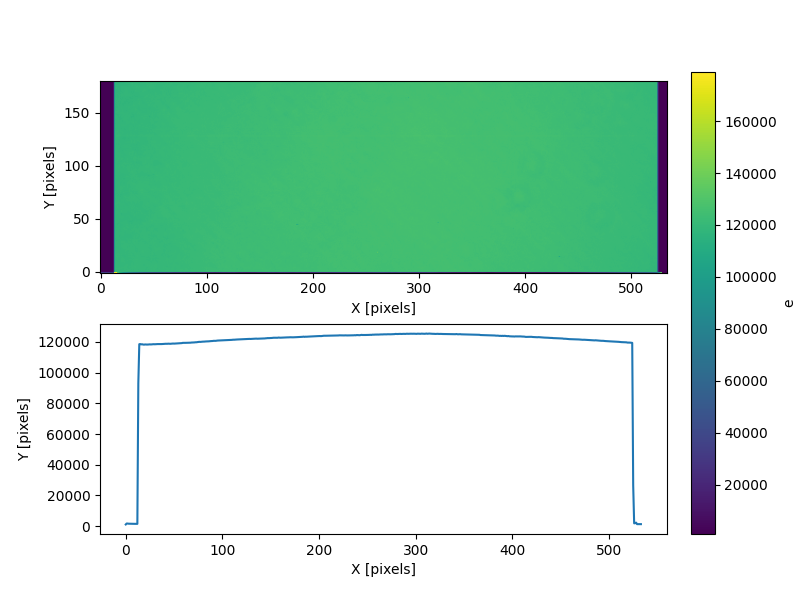

In [15]:
fig, ax = plt.subplots(2,1, figsize=(8,6)) # Caution, figsize will also influence positions.
im1 = ax[0].imshow(flat00_data, origin='lower')
median_column = np.average(flat00_data, axis=0)
im2 = ax[1].plot(median_column)

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
cbar = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
# fraction=0.046 Определяет долю цветовой шкалы от общей высоты (если график вертикальный) 
# или ширины (если горизонтальный)
# pad=0.04 Указывает на расстояние между изображением и цветовой шкалой.
cbar.set_label("e")

ax[0].set_xlabel('X [pixels]')
ax[0].set_ylabel('Y [pixels]')

ax[1].set_xlabel('X [pixels]')
ax[1].set_ylabel('Y [pixels]')
plt.show()

# we plot the average distribution of counts as a function of the column number
# (среднего распределения значений по столбцам), 
# we can see that there are two strips on the side of the image with a much 
# lower number of counts 
# Each column takes the name of **overscan** acting like a local bias
# The overscan is a portion of CCD chip that is not exposed to light. 
# In some cameras this is literally several extra rows and/or columns 
# that are not exposed to light while in others the overscan is produced 
# electronically. It can be useful if the bias level changes over the course of a night


#### Handling Overscan Regions

Overscan areas don't affect data analysis but can be annoying for stats and display
Two solutions are:

* Trim outer columns from images and save them,
* Exclude these columns in analysis and visualization,

Trimming is common but requires software to maintain metadata and consistent cuts. It also needs extra storage. Excluding columns is simpler and requires careful attention.

In [23]:
# we compute the minimum and maximum values of our counts, excluding the overscan regions
vmin = np.amin(flat00_data[:, 12:-12])
vmax = np.amax(flat00_data[:, 12:-12])
print(vmin, vmax)

#7947.03 178910.55

1223.04 178910.55


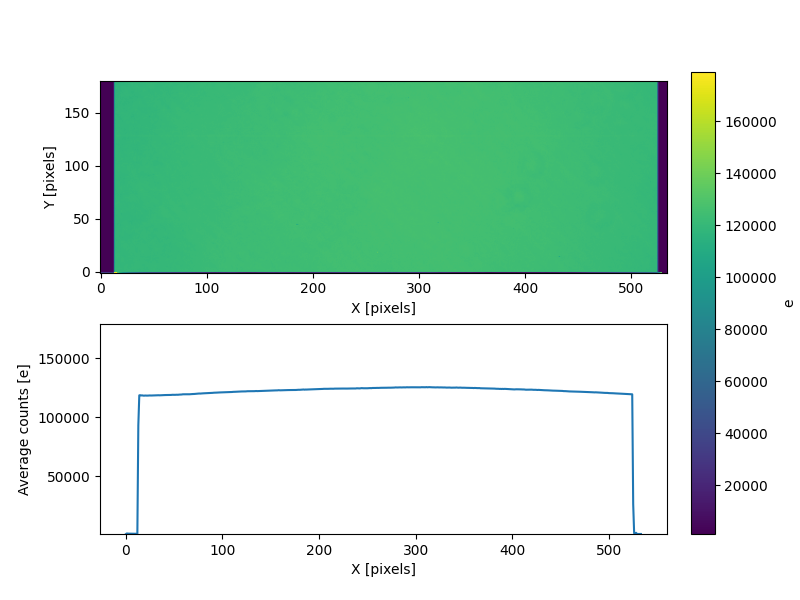

In [28]:
fig, ax = plt.subplots(2,1, figsize=(8,6)) # Caution, figsize will also influence positions
# im1 = ax[0].imshow(flat00_data[:,20:490], origin='lower', vmin=vmin, vmax=vmax, cmap='magma')
im1 = ax[0].imshow(flat00_data, origin='lower', vmin=vmin, vmax=vmax)
# median_column = np.average(flat00_data[:,20:490], axis=0)
median_column = np.average(flat00_data, axis=0)
im2 = ax[1].plot(median_column)

# we set the plot limits 
ax[1].set_ylim(vmin,vmax)

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
cbar = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("e")

ax[0].set_xlabel('X [pixels]')
ax[0].set_ylabel('Y [pixels]')

ax[1].set_xlabel('X [pixels]')
ax[1].set_ylabel('Average counts [e]')
plt.show()


#### Computing the normalization factors
Computation of the median flat follows a similar strategy adopted for the median bias:

1. we initialize a 3D array called stack [dimensions equal to the number of images and the two dimensions of a frame]
2. we read the frames one by one, correct for bias, and store them in the stack

In [31]:
# stack where we store our immages

n_images = len(flat_list)

flat00_nparray_dim00, flat00_nparray_dim01 = np.shape(flat00_data)
#flat00_dim00, flat00_dim01 = np.shape(flat00_data)

stack = np.empty([n_images, flat00_nparray_dim00, flat00_nparray_dim01])
#stack = np.empty([n_images, flat00_dim00, flat00_dim01])

for i_flat, flat_name in enumerate(flat_list):
    flat_temp = fits.open('./flat/'+flat_name)
    stack[i_flat,:,:] = flat_temp[0].data * flat_temp[0].header['GAIN'] - median_bias
    flat_temp.close()

30


### Goal of flat calibration
To compensate for any non-uniformity in the response of the CCD to light
Several reasons for the non-uniform response across the detecto:

* variations in the sensitivity of pixels in the detector
* dust on the filter / the glass window covering the detector
* vignetting, a dimming in the corners of the image
* anything else in the optical path that affects how much light reaches the sensor

* we want to reach the highest signal-to-noise ratio for every pixel
* photon noise goes with the square root of the flux -> we need very high counts 
* dividing science frames by very high counts produce unrealistically small photoelectron fluxe
* we are interested in relative response of pixels, i.e., how the pixels behave with respect to the others, 
* NOT to the absolute efficiency of each pixel
* We can express the flat correction as the correction value relative to the median response over a selected sample of pixels

In [29]:
median_bias = pickle.load(open("median_bias.p", "rb"))
median_bias_error = pickle.load(open("median_bias_error.p", "rb"))

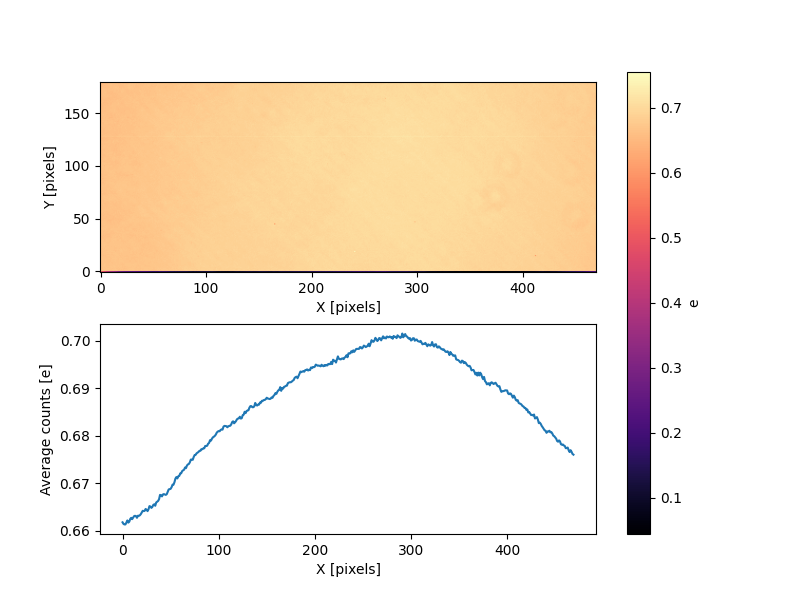

In [31]:
"""
fig, ax = plt.subplots(2,1, figsize=(8,6)) # Caution, figsize will also influence positions.
im1 = ax[0].imshow(flat00_data[:,20:490]/vmax, origin='lower', cmap='magma')
median_column = np.average(flat00_data[:,20:490]/vmax, axis=0)
im2 = ax[1].plot(median_column)

cbar = fig.colorbar(im1, ax=ax)
cbar.set_label("e")

ax[0].set_xlabel('X [pixels]')
ax[0].set_ylabel('Y [pixels]')

ax[1].set_xlabel('X [pixels]')
ax[1].set_ylabel('Average counts [e]')
plt.show()
"""

# тут что-то не так с графиком. он должен быть равномерным

In [32]:
windows_size = 50
#x0 = np.int16(flat00_nparray_dim01/2 - window_size/2)
#y0 = np.int16(flat00_dim00/2 - window_size/2)
#x1 = np.int16(flat00_dim01/2 + window_size/2)
#y1 = np.int16(flat00_dim00/2 + window_size/2)


# x0, x1, y0, y1 represents the coordinates of the four corners
x0 = np.int16(flat00_nparray_dim01/2 - windows_size/2)
x1 = np.int16(flat00_nparray_dim01/2 + windows_size/2)
y0 = np.int16(flat00_nparray_dim00/2 - windows_size/2)
y1 = np.int16(flat00_nparray_dim00/2 + windows_size/2)

print('Coordinates of the box: x0:{0}, x1:{1}, y0:{2}, y1:{3}'.format(x0, x1, y0, y1))

#print('maximum', vmax)
#print('median:', np.median(flat00_data[y0:y1, x0:x1]))

#median_value = np.median(flat00_data[y0:y1, x0:x1])

Coordinates of the box: x0:242, x1:292, y0:65, y1:115


1. In the case of the **bias frame**, we wanted to compute the median across the 30 bias frames for each pixel, so we set axis=0, and the output was the same size as a frame
В случае с кадрами смещения нужно было вычислить медиану по 30 кадрам для каждого пикселя, используя axis=0, так что результат имел такой же размер, как один кадр.


2. Here, we want to compute the median of a given set of pixels for each frame, and the resulting array should be the same size as the number of frames
Здесь же мы хотим вычислить медиану заданного набора пикселей для каждого кадра, причем результат будет иметь размер, равный количеству кадров

To accomplish this, it is sufficient to specify the two axes we want to include in computing the median, using round parenthesis as in the example below. The median will be calculated using all the values in the range [y0:y1, x0:x1] of each frame

tuple:
* a collection which is ordered 
* unchangeable
* elements can be duplicated, 
* and of different types


In [33]:
normalization_factor = np.zeros(n_images)

for i_flat in range(0, n_images):
    normalization_factor[i_flat] = np.median(stack[i_flat, y0:y1, x0:x1])

print(normalization_factor)

[124572.63   124397.91   124874.295  124829.25   125118.63   125484.45
 126138.285  125641.425  125400.5025 124913.88   124903.6425 124969.845
 124758.27   125227.83   125646.885  125853.     125801.13   126063.21
 125987.4525 126445.41   126693.84   126715.68   126371.7    125468.07
 125141.835  124954.83   125997.69   126204.4875 126196.98   125570.445 ]


In [34]:
#normalization_factor_axis = np.median(stack[:, y0:y1, x0:x1], axis=(1,2))
#print(normalization_factor_axis)

normalization_factors = np.median(stack[:,y0:y1, x0:x1], axis=(1,2))
print('Number of normalization factors (must be the same as the number of frames): {0}'.format(np.shape(normalization_factors)))
print(normalization_factors)

Number of normalization factors (must be the same as the number of frames): (30,)
[124572.63   124397.91   124874.295  124829.25   125118.63   125484.45
 126138.285  125641.425  125400.5025 124913.88   124903.6425 124969.845
 124758.27   125227.83   125646.885  125853.     125801.13   126063.21
 125987.4525 126445.41   126693.84   126715.68   126371.7    125468.07
 125141.835  124954.83   125997.69   126204.4875 126196.98   125570.445 ]


In [20]:
normalization_factor_test = np.median(stack[:, y0:y1, x0:x1], axis=0)
print(np.shape(normalization_factor_test))

(50, 50)


Here's the formula being computed in the code:

1. **Standard Deviation:**

   $$
   \sigma_{\text{region}} = \text{np.std}(stack[:, y0:y1, x0:x1], \, \text{axis}=(1,2))
   $$


2. **Normalization:**

   $$
   \text{normalization\_factors\_std} = \frac{\sigma_{\text{region}}}{\sqrt{\text{windows\_size}^2}}
   $$

   This divides the standard deviation by the square root of the number of pixels in the region (`windows_size^2`), providing an approximate error for each frame's normalization factor.


In [36]:
normalization_factors_std = np.std(stack[:,y0:y1, x0:x1], axis=(1,2)) / np.sqrt(windows_size**2)
# An approximated error for our normalization factor 
# by computing the standard deviation inside the box 
# (which would represent the error associated with each pixel) 
# and then dividing the square root of the number of points inside the box. 
print(normalization_factors_std)

[11.84930302 11.88693875 11.84684029 12.00085807 12.12111951 12.08813705
 12.01711456 11.9609602  11.91691342 12.36373539 12.07189485 12.08752627
 11.97861359 11.82232377 11.89796161 12.19321543 12.08848788 12.1425676
 11.97503684 12.0536117  12.05466875 12.12054321 12.3615749  12.08054868
 12.09796319 11.88364343 12.07278258 12.00738685 12.36402405 12.26625801]


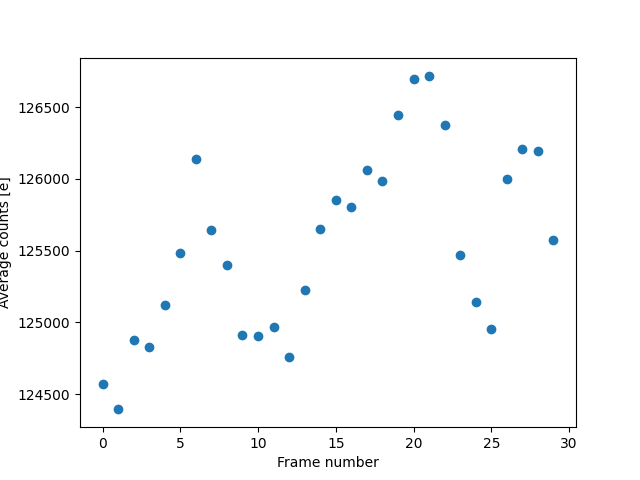

In [42]:
#test:
#x_axis = np.arange(0, 30.1, 1)
#print(x_axis)
#x_axis = np.arange(0, 30, 1.)
#print(x_axis)

#plt.figure(figsize=(6,4))
#plt.scatter(x_axis, normalization_factors)
#plt.show()

#x_axis = np.arange(0, 521, 1.)
#plt.figure(figsize=(6,4))
#plt.scatter(x_axis, np.average(stack[0,:,:])/normalization_factor_axis[0]), axis=1), s=2)
#plt.scatter(x_axis, np.average(stack[1,:,:])/normalization_factor_axis[1], axis=1), s=2)
#plt.ylim(0.85, 1.01)
#plt.show()

plt.figure()
x_frame = np.arange(0, n_images, 1)
plt.scatter(x_frame, normalization_factors)
plt.errorbar(x_frame, normalization_factors, normalization_factors_std, fmt='o', ms=1)
plt.xlabel('Frame number')
plt.ylabel('Average counts [e]')
plt.show()


From the plot above, we can see that the normalization factor is **not constant** from one image to another, 

although we would expect to measure the same flux for each pixel, as we are observing a fixed lamp for a predetermined exposure time. 

These oscillations are caused by a **lamp problem** discovered only some time after its installation. 
Depending on when your data has been gathered, you may not see this feature

This is the main reason why **we perform the normalization before computing the median flat**. If the lamp's flux was perfectly constant across the frames, the order of normalization and median computation would not have mattered. Note that we have to perform the normalization anyway, 
as we are interested in computing the **sensor relative efficiency**

**sensor relative efficiency** насколько эффективно разные пиксели сенсора улавливают свет по отношению друг к другу. Она учитывает вариации в чувствительности пикселей и обеспечивает калибровку отклика каждого пикселя до общего стандарта

In [80]:
temp = np.average(stack[0, :, :]) / normalization_factor_axis[0], axis=0)
np.shape(temp)

SyntaxError: cannot assign to operator (2477597635.py, line 1)

#### Flat normalization
To normalize each frame by its corresponding normlization factor, we can proceed in two ways:

1. iterate along the frame, and perform the operation:


In [ ]:
#stack_normalized_iter = stack * 0. 
#stack_normalized_iter = np.zeros_like(stack)

#for i_flat in range(0, n_images):
#    stack_normalized_iter[i_flat, :, :] = stack[i_flat, :, :] / normalization_factors[i_flat]
#print(stack_normalized_iter[:, y0, x0])

stack_normalized_iter =  stack * 0. #initialization of the output array
for i_flat in range(n_images):
    stack_normalized_iter[i_flat,:,:] = stack[i_flat,:,:] / normalization_factors[i_flat]

2. use the broadcasting feature

Broadcasting allows arithmetic operations between arrays with different shapes. 

Broadcasting в NumPy начинает работать с последней (правой) размерности и движется влево. Это значит, что NumPy пытается подобрать размеры массивов, начиная с их крайней правой стороны. Если у нас есть массивы, которые не подходят друг другу по форме, как в случае, когда normalization_factors совпадают с левой размерностью stack, то можно использовать транспонирование, чтобы исправить это.

1. Транспонирование массива : 
Изменяем порядок размерностей массива stack с помощью .T. Это позволяет переставить оси таким образом, чтобы они правильно согласовывались с normalization_factors.

2. Операция на транспонированных массивах : 
Проводим необходимые операции (например, сложение или вычитание) между транспонированным массивом и normalization_factors.

3. Возврат к исходной форме : После выполнения операций снова транспонируем результат обратно, чтобы вернуть оригинальную форму массива.

In [44]:
print("shape of stack array           : ", np.shape(stack))
print("shape of transposed stack array: ", np.shape(stack.T))

stack_normalized = (stack.T / normalization_factors).T
## First alternative:  stack_normalized = np.divide(stack.T, normalization_factors).T 
## Second alternative: stack_normalized = np.multiply(stack.T, 1./normalization_factors).T 

print("shape of normalized stack array: ", np.shape(stack_normalized))

shape of stack array           :  (30, 180, 534)
shape of transposed stack array:  (534, 180, 30)
shape of normalized stack array:  (30, 180, 534)


We can verify if the two methods deliver the same results by checking the maximum deviations between the two arrays in absolute terms


In [46]:
print("Maximum absolute difference between the two arrays: {0:2.6e}".format(np.max(np.abs(stack_normalized_iter-stack_normalized))))

Maximum absolute difference between the two arrays: 0.000000e+00


The value may not be zero due to the computer's precision: 

Epsilon describes the round-off error for a floating-point number with a certain amount of precision. It can be thought of as the smallest number that can be added to 1.0 without changing its bits

Значение может не быть нулевым из-за точности компьютера:
Эпсилон описывает ошибку округления для числа с плавающей запятой при определенной точности. Его можно представить как наименьшее число, которое можно добавить к 1.0, не изменяя его двоичное представление

In [47]:
print(np.finfo(float).eps)

2.220446049250313e-16


#### Median flat
We can finally compute the median normalized flat frame and store it on the computer:

In [48]:
median_normalized_flat = np.median(stack_normalized, axis=0) 
# вычисляет медианное значение для каждого пикселя по всем кадрам в stack_normalized
# Результатом является одномерный массив, представляющий медианное нормализованное 
# плоское поле, исправляющее неоднородности

pickle.dump(median_normalized_flat, open("median_normalized_flat.p", "wb")) 
# сохраняет рассчитанное медианное нормализованное плоское поле в файл median_normalized_flat

pickle.dump(stack_normalized, open("flat_normalized_stack.p", "wb")) 
# сохраняет весь стек нормализованных кадров в файл flat_normalized_stack

pickle.dump(normalization_factors, open("flat_normalization_factors.p", "wb")) 
# сохраняет нормализационные факторы, использованные для каждого кадра, 
# в файл "flat_normalization_factors.p"

pickle.dump(stack, open("flat_stack.p", "wb")) 
# сохраняет исходный стек кадров до нормализации в файл "flat_stack.p"

i_image = 0
nmin = np.amin(median_normalized_flat[:, 12:-12])
nmax = np.amax(median_normalized_flat[:, 12:-12])
print(vmin, vmax)


1223.04 178910.55


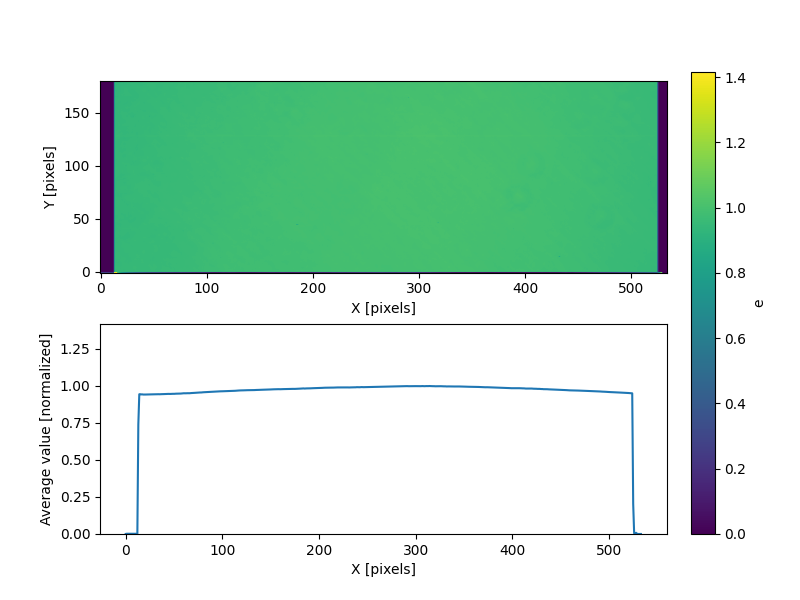

In [49]:
fig, ax = plt.subplots(2,1, figsize=(8,6)) # Caution, figsize will also influence positions.
im1 = ax[0].imshow(median_normalized_flat, origin='lower', vmin=nmin, vmax=nmax)
median_column = np.average(median_normalized_flat, axis=0)
im2 = ax[1].plot(median_column)

# we set the plot limits 
ax[1].set_ylim(nmin,nmax)

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
cbar = fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("e")

ax[0].set_xlabel('X [pixels]')
ax[0].set_ylabel('Y [pixels]')

ax[1].set_xlabel('X [pixels]')
ax[1].set_ylabel('Average value [normalized]')
plt.show()

### Error propagation

Regarding the **bias frames**, the readout noise *RON* -> was the only contributor to the noise budget 

Now, we have three contributors:

* the readout noise **RON** - done
* the error **associated with the median bias** frame - done
* the photon noise **associated with the flux** of the lamp
* (**dark current** would contribute as well, but it can be **neglected** for short exposures and for modern detectors in general)




We can assume that during the exposure time, photons 
* hit the detector at a steady (постоянной) average rate, 
* each photon arrival is random and independent of the others

This follows a Poisson distribution, meaning the variability (variance - дисперсия) in photon detections 
is equal to the actual number of detected photons

*variance* (i.e., the expected value of the squared deviation from the mean of a random variable.)

In [52]:
#Noting that we have already removed the bias value (which does not contribute to the photon noise), 
#the photon noise associated with each measurement of each frame is given by the square root of the stack 
#(квадратный корень потому что статистика Пуассона)

#photon_noise = np.sqrt(stack)
photon_noise = np.sqrt(np.abs(stack))

In [53]:
# The total error associated with each frame **BEFORE** normalization
# is the root of the sum of squares of individual errors,
# as only additions and subtractions are involved in these data reduction steps

stack_error = np.sqrt(readout_noise **2 + bias_std**2 +  photon_noise**2)

#Normalization is simply the division by a constant that we assume is errorless. 
# According to the error propagation formula, we need to divide the error estimates by the same values



In [54]:
stack_normalized_error = (stack_error.T/normalization_factors).T 

### Associated with the median flat

Finally, the error associated with the median flat can be computed by assuming that the _median function_ (which cannot be expressed analytically) can be approximated by the _mean function_, which instead has an analytical expression and thus can be used with the error propagation formula.

**Note:** This is a strong assumption that we are making here specifically for our study case. In general, you should always check if you are working in a regime of white noise.

1. The formula for the mean is given by:

$$
f = \frac{1}{N} \sum_{i=1}^{N} f_i
$$

2. And the formula for the associated error is:

$$
\sigma_f = \frac{\sqrt{\sum_{i=1}^{N} \sigma_i^2}}{N}
$$
используется для оценки суммарной ошибки в средней величине, учитывая индивидуальные ошибки 

In [56]:
median_normalized_flat_errors = np.sum(stack_normalized_error**2, axis=0) / n_images
print("shape of the median normalized error array: ", np.shape(median_normalized_flat_errors))

pickle.dump(median_normalized_flat_errors, open("median_normalized_flat_errors.p", "wb")) 

shape of the median normalized error array:  (180, 534)


#### Some statistics on the flat

1. why normalize first, and then computing the median? Can I change the order without consequences?

2. Сравнение распределений : 
    Рассматривается участок пикселей ([100:105, 250:255]) перед и после нормализации.
    Гистограмма строится для необработанных пиксельных значений (Before norm.) и для нормализованных (After norm.).
    Нормализованные значения масштабируются к среднему значению нормализации, чтобы сделать сравнение более прямым.

3. Ожидания и реальность :
    Теоретически, если поток лампы остается постоянным, распределения до и после нормализации должны быть похожи.
    Различие в распределениях указывает на неравномерность, не связанную с простым фотонным шумом.

/var/folders/3w/7g5zt5xj0jn5c1q54g2z15wc0000gq/T/ipykernel_59551/1225176813.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


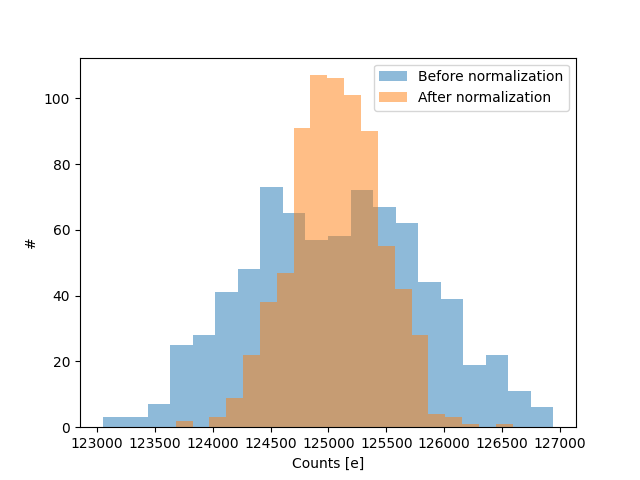

In [58]:
mean_normalization = np.mean(normalization_factors)

plt.figure()
plt.hist(stack[:,40:45,250:255].flatten(), bins=20, alpha=0.5, label='Before normalization')
plt.hist(stack_normalized[:,40:45,250:255].flatten()*mean_normalization, bins=20, alpha=0.5, label='After normalization')
plt.xlabel('Counts [e]')
plt.ylabel('#')
plt.legend()
plt.show()

Here is a clear difference between the two distributions (can you quanitfy it)? 

The reason appears clear if we plot the distribution of the normalization factors, and we compare it with the theoretical distribution that they should have if the variations was due to photon noise alone.

To compute the normal distribution, I assumed  $\sigma = \sqrt{f_{avg}}$

It appears clear that the variation in the illumination by the flat lamp is not consistent with photon noise alone. After technical investigation, a fluctuations in the voltage of the lamp has been discovered.

For this reason, we performed the normalization, i.e., removing the variation of illumination with time, before computing the median.

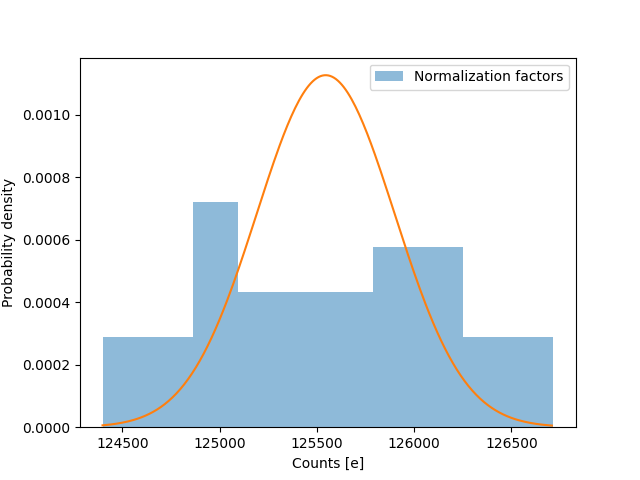

In [59]:
sigma_mean_normalization = np.sqrt(mean_normalization)
x = np.arange(np.amin(normalization_factors), np.amax(normalization_factors), 10)
y = 1./(sigma_mean_normalization * np.sqrt(2 * np.pi)) * \
               np.exp( - (x - mean_normalization)**2 / (2 * sigma_mean_normalization**2) )

plt.figure()
plt.hist(normalization_factors,alpha=0.5, density=True, label='Normalization factors')
plt.plot(x,y)
plt.xlabel('Counts [e]')
plt.ylabel('Probability density')
plt.legend()
plt.show()